■[Detic:Detecting Twenty-thousand Classes using Image-level Supervision](https://arxiv.org/abs/2201.02605v2)


▷Step 1: Check torch and cuda version

In [1]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.13 ; cuda:  cu116


▷Step 2: Install detectron2

In [2]:
!pip install git+https://github.com/facebookresearch/detectron2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2 to /tmp/pip-req-build-wtkj0ys6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2 /tmp/pip-req-build-wtkj0ys6
  Resolved https://github.com/facebookresearch/detectron2 to commit dc9ad7055b48f25ab0a13e817c1a427b1385f98a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6

▷Step 3: Git clone and install Detic

In [3]:
# clone and install Detic
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
%cd Detic
!pip install -r requirements.txt

Cloning into 'Detic'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 206 (delta 34), reused 21 (delta 21), pack-reused 141
Receiving objects: 100% (206/206), 3.58 MiB | 2.33 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Submodule 'third_party/CenterNet2' (https://github.com/xingyizhou/CenterNet2.git) registered for path 'third_party/CenterNet2'
Submodule 'third_party/Deformable-DETR' (https://github.com/fundamentalvision/Deformable-DETR.git) registered for path 'third_party/Deformable-DETR'
Cloning into '/content/Detic/third_party/CenterNet2'...
remote: Enumerating objects: 13925, done.        
remote: Counting objects: 100% (949/949), done.        
remote: Compressing objects: 100% (101/101), done.        
remote: Total 13925 (delta 887), reused 854 (delta 846), pack-reused 12976        
Receiving objects: 100% (13925/13925), 5.08 MiB | 16.89 MiB/s, done.
Resolving deltas: 100%

▷Step 4: Setup env for using Detic

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Detic libraries
sys.path.insert(0, '/content/Detic/third_party/CenterNet2')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

▷Step 5: Build the detector and download our pretrained weights

In [5]:
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True # For better visualization purpose. Set to False for all classes.
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/03 06:12:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...


Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth: 702MB [05:05, 2.30MB/s]                           


▷Step 6: Select your photo

In [6]:
from google.colab import files
uploaded = files.upload()
uploaded = list(uploaded.keys())
print(uploaded)

Saving animal_demo.jpg to animal_demo.jpg
['animal_demo.jpg']


▷Step 7: Select vocabulary datasets

In [8]:
# Setup the model's vocabulary using build-in datasets

BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

vocabulary = 'lvis' # change to 'lvis', 'objects365', 'openimages', or 'coco'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


▷Step 8: Run Segmentation 

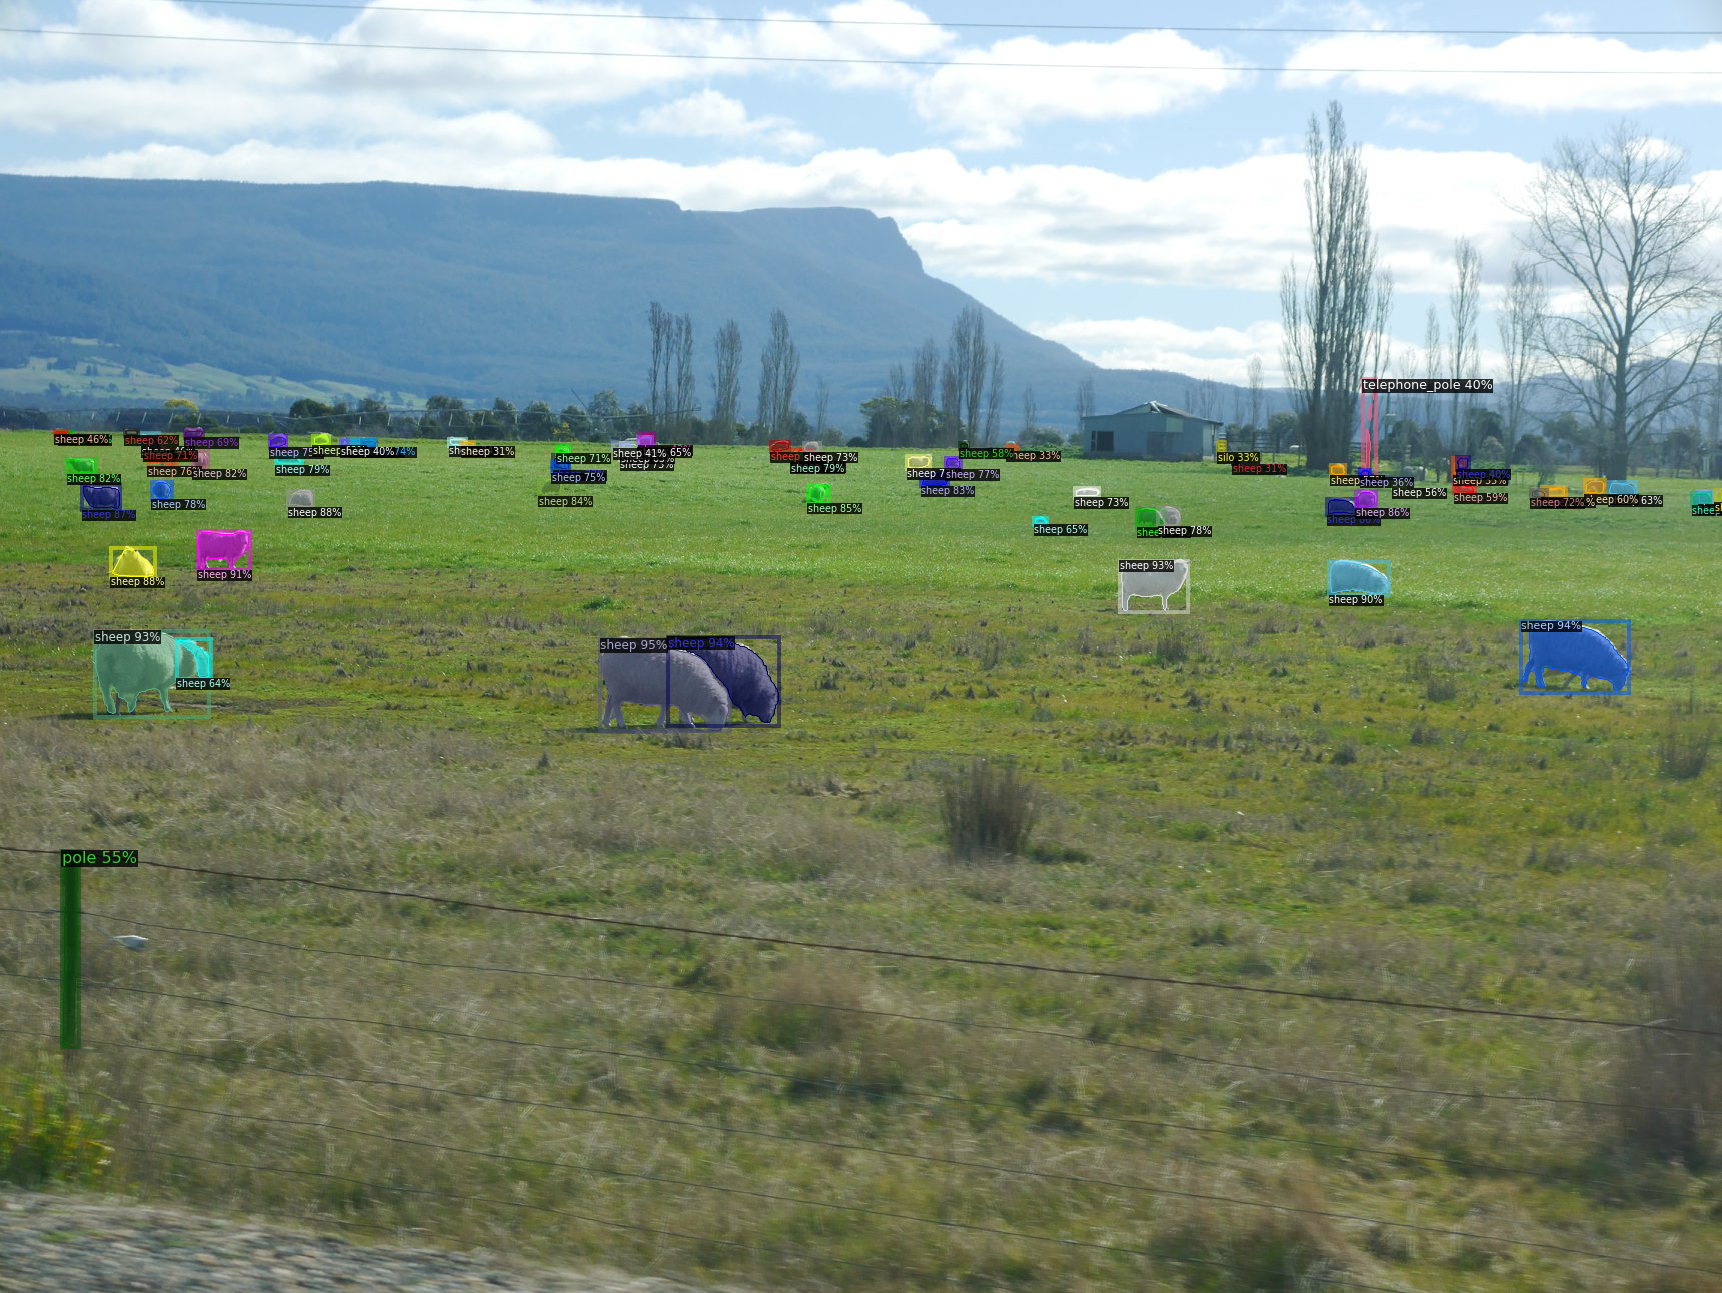

In [9]:
for file in uploaded:
  im = cv2.imread(file)

  # Reset visualization threshold
  output_score_threshold = 0.3
  for cascade_stages in range(len(predictor.model.roi_heads.box_predictor)):
    predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

  # Run model and show results
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1], metadata)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

Loading pretrained CLIP


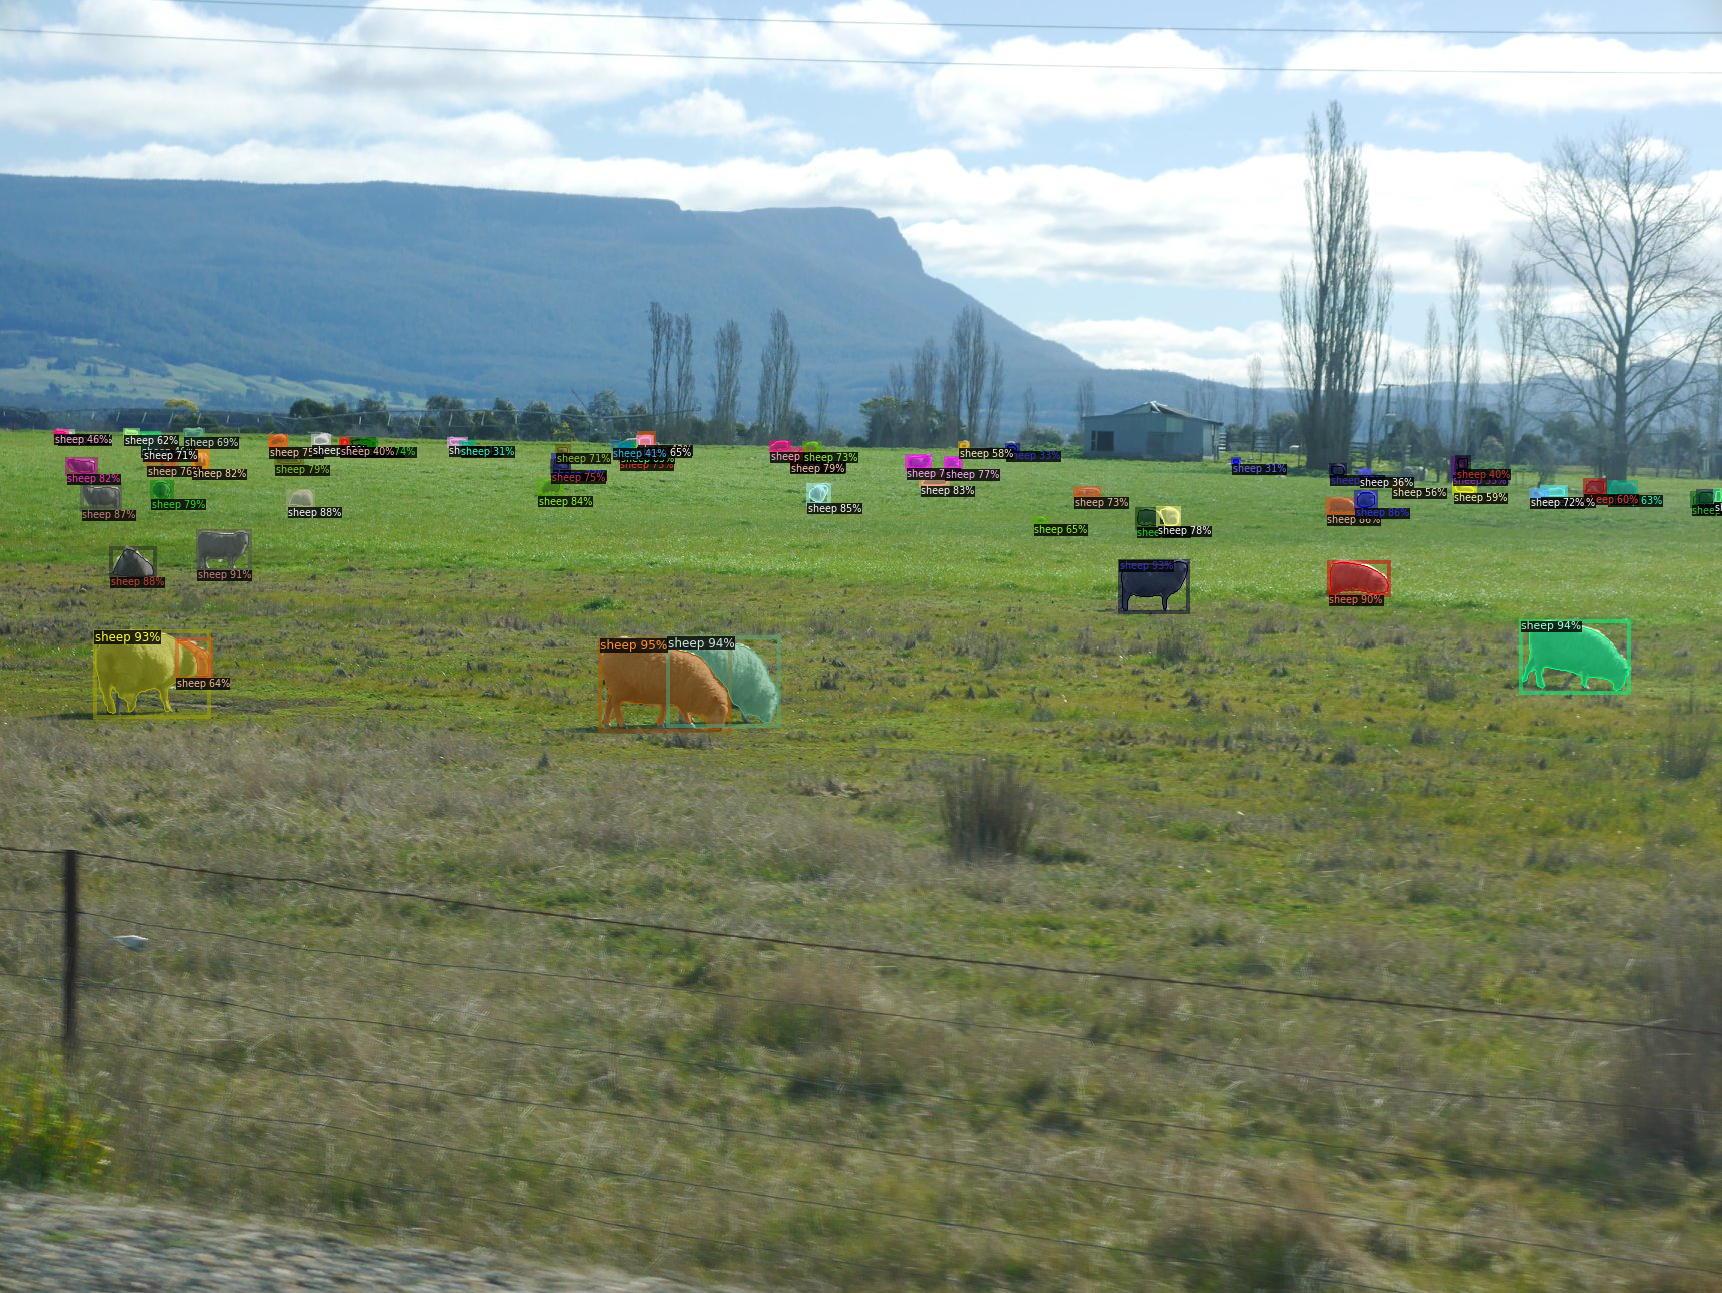

In [12]:
from detic.modeling.text.text_encoder import build_text_encoder
def get_clip_embeddings(vocabulary, prompt='a '):
    text_encoder = build_text_encoder(pretrain=True)
    text_encoder.eval()
    texts = [prompt + x for x in vocabulary]
    emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
    return emb

vocabulary = 'custom'
metadata = MetadataCatalog.get("__unused")

#@title Please input object name
#@markdown Please input object name
detect_target = 'sheep' #@param {type:"string"}

metadata.thing_classes = [detect_target]

classifier = get_clip_embeddings(metadata.thing_classes)
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

for file in uploaded:
  im = cv2.imread(file)

  # Reset visualization threshold
  output_score_threshold = 0.3
  for cascade_stages in range(len(predictor.model.roi_heads.box_predictor)):
    predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

  # Run model and show results
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1], metadata)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

del metadata.thing_classes